## 1. Libraries

In [1]:
import pandas as pd
from sklearn.feature_extraction.text import CountVectorizer
from thefuzz import fuzz
from sklearn.metrics.pairwise import cosine_similarity
import numpy as np
from matplotlib import pyplot as plt
import networkx as nx
import gravis as gv
from sklearn.model_selection import train_test_split
import math

## 2. Read Data<br>


In [2]:
df = pd.read_csv('clustered_typos.csv',index_col=0)

In [3]:
df.head()

word    cluster
0   Chasney    Chansey
1  Nidqueen  Nidoqueen
2    GAstly     Gastly
3    Vulpix     Vulpix
4     Gasly     Gastly

<Axes: title={'center': 'Size of Clusters'}, xlabel='Clusters', ylabel='Size'>

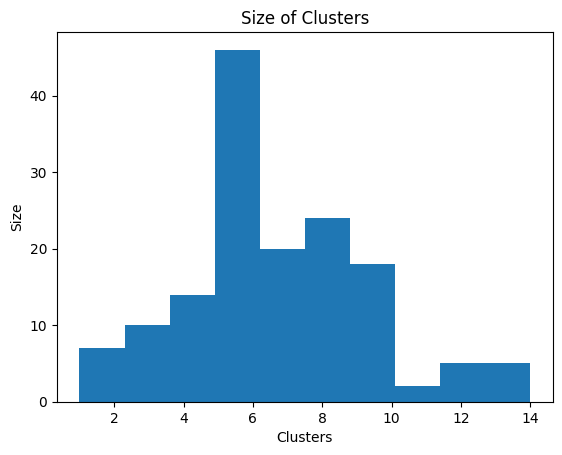

In [4]:
df.groupby('cluster').count().plot(kind='hist',title='Size of Clusters',xlabel='Clusters', ylabel='Size', legend=None)

Mean cluster size

In [5]:
df.groupby('cluster').count().mean()

word    6.622517
dtype: float64

Clusters sorted by size

In [6]:
df.groupby('cluster').count().sort_values(by='word')

word
cluster         
Nidoqueen      1
Nidoranf       1
Weezing        2
Tauros         2
Seaking        2
...          ...
Weepinbell    13
Horsea        13
Caterpie      14
Clefairy      14
Cloyster      14

[151 rows x 1 columns]

Get names

In [7]:
unique_words = list(set(df['word']))

## 3. Name Clustering

Prepare and normalize text input

In [8]:
def normalize(text: set)->list:
    'transform every word in text to lower case'
    return [text[word].lower() if text[word] is not None else '' for word in range(len(text))]

In [9]:
text = normalize(unique_words)

Here more pre processing of the string is possible, but due to the given input not needed.

### 3.1 Similarity Metrics

#### 3.1.1 Cosine Similarity

In [10]:
def cos_sim(text: list)->np.array:
    'calculate the cosine similarity for every word in text'
    
    sep_list = [list(text[i]) for i in range(len(text))]
    corpus = [' '.join(sep_list[i]) for i in range(len(sep_list))]
    vect = CountVectorizer(tokenizer=lambda txt: txt.split(' '))
    X = vect.fit_transform(corpus)
    X = X.toarray()
    cos_array = cosine_similarity(X, X)

    #Set similarity to its own to 0
    for i in range(len(cos_array)):
        cos_array[i][i]=0
    
    return cos_array

In [11]:
cos_array = cos_sim(text)

c:\Users\G23236\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\feature_extraction\text.py:525: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


#### 3.1.2 Fuzz Ratio

In [12]:
def fuzz_ratio(text: list)->np.array:
    'calculate the fuzz/levenshtein similarity for every word in text'

    #Initiate empty cluster matrix
    mat_cluster = np.zeros([len(text),len(text)],dtype=np.int8)

    #Calculate fuzz similarity for every possible unique combination
    for idx1, w1 in enumerate(text):
        for idx2, w2 in enumerate(text):
            mat_cluster[idx1, idx2] = fuzz.ratio(w1, w2)

    #Scale ratio betwenn 0 and 1
    mat_cluster = mat_cluster / 100

    #Set similarity to its own to 0
    for i in range(len(mat_cluster)):
        mat_cluster[i][i] = 0

    return mat_cluster

In [13]:
fuzz_array = fuzz_ratio(text)

#### 3.1.3 Sub String Clustering

In [14]:
def sub_string(text: list, MIN_LEN_SUB=2)->np.array:
    'calculate the sub string similarity for every word in text'

    #Initiate empty cluster matrix
    mat_cluster = np.zeros([len(text),len(text)],dtype=np.int8)

    #Calculate sub string similarity for every possible unique combination
    for w1 in range(len(text)):
        if len(text[w1]) > MIN_LEN_SUB:
            for w2 in range(len(text)):
                if len(text[w2]) > MIN_LEN_SUB and w1 != w2:
                    if text[w1] in text[w2]:
                        mat_cluster[w1,w2] = 1
    
    #Mirror Similarity-Score in matrix
    for i in range(len(mat_cluster[:,0])):
        for j in range(len(mat_cluster[0,:])):
            mat_cluster[i,j] = mat_cluster[j,i] = max(mat_cluster[i,j],mat_cluster[j,i])
    
    return mat_cluster

In [15]:
sub_array = sub_string(text)

#### 3.1.4 Jaccard Similarity

In [16]:
def jaccard(text:list)->np.array:
    'calculate the cosine similarity for every word in text'
    
    #Initiate empty cluster matrix
    mat_cluster_2 = np.zeros([len(text),len(text)])

    #Calculate jaccard similarity for every possible unique combination
    for idx1, w1 in enumerate(text):
        for idx2, w2 in enumerate(text[:idx1]):
            inter = set(text[idx1]).intersection(set(text[idx2]))
            un = set(text[idx1]).union(set(text[idx2]))
            mat_cluster_2[idx1, idx2] = len(inter) / len(un)

    #Mirror Similarity-Score in matrix
    for i in range(len(mat_cluster_2[:,0])):
        for j in range(len(mat_cluster_2[0,:])):
            mat_cluster_2[i,j] = mat_cluster_2[j,i] = max(mat_cluster_2[i,j],mat_cluster_2[j,i])
            
    return mat_cluster_2

In [17]:
jac_array = jaccard(text)

### 3.2 Define Cluster-Class and Functions

In [18]:
class name_clustering:
    
    def __init__(self):
        pass

    def matrix(self, matrix, weight_list):
        'build weighted combined matrix of all input matrices'
        
        if len(matrix.shape) == 2:
            assert len(weight_list) == 1

            #Initialize weighted matrix
            self.weighted_matrix = np.zeros_like(matrix)

            #Fill weighted matrix
            dimension = 0
            self.weighted_matrix += weight_list[dimension] * matrix[:,:]

        else:
            #Initialize weighted matrix
            self.weighted_matrix = np.zeros_like(matrix[0])

            #Fill weighted matrix
            for dimension in range(len(weight_list)):
                self.weighted_matrix += weight_list[dimension] * matrix[dimension, :, :]
        
        return self.weighted_matrix

    def create_adjacency_matrix_strict(self, matrix, THRESHOLD):
        'build adjacency matrix of weighted matrix'

        #build adjacency matrix
        num_words = len(matrix)
        self.adjacency_matrix = [[0]*num_words for _ in range(num_words)]

        def in_same_cluster(word1, word2):
            'Check if words are in the same cluster'
            return matrix[word1][word2] > THRESHOLD

        def check_cluster(cluster):
            'Check if all words in cluster have the needed similarity'
            for i in range(len(cluster)):
                for j in range(i + 1, len(cluster)):
                    if not in_same_cluster(cluster[i], cluster[j]):
                        return False
            return True

        #Iterate over each pair of words and update the adjacency matrix
        for i in range(num_words):
            for j in range(i + 1, num_words):
                if in_same_cluster(i, j):
                    self.adjacency_matrix[i][j] = 1
                    self.adjacency_matrix[j][i] = 1

        #Iterate over each pair of words outside the cluster and reset their connection
        for i in range(num_words):
            for j in range(num_words):
                if not in_same_cluster(i, j):
                    self.adjacency_matrix[i][j] = 0
                    self.adjacency_matrix[j][i] = 0

        #Iterate over each cluster and check the minimum similarity
        for i in range(num_words):
            cluster = [j for j in range(num_words) if self.adjacency_matrix[i][j] == 1]
            if not check_cluster(cluster):
                for j in cluster:
                    self.adjacency_matrix[i][j] = 0
                    self.adjacency_matrix[j][i] = 0
        
        return self.adjacency_matrix
        
    def create_adjacency_matrix(self, matrix, THRESHOLD):
        'build adjacency matrix of weighted matrix'

        self.adjacency_matrix = matrix.copy()
        self.adjacency_matrix[self.adjacency_matrix>THRESHOLD] = 1
        self.adjacency_matrix[self.adjacency_matrix<=THRESHOLD] = 0
                    
        return self.adjacency_matrix


In [19]:
def create_y(words: pd.Series, df: pd.DataFrame)->np.array:
    'create y as adjacency matrix'

    # Initialize empty array
    te = np.arange(len(words)*len(words))
    tes = np.reshape(te,[len(words), len(words)])
    y = np.zeros_like(tes)

    #Transform clusters to array
    for i in range(len(df)):
        cluster = df.loc[i]['cluster']
        neighbors = list(df[df['cluster']==cluster]['word'])
        neighbor_idxs = []
        for neighbor in neighbors:
            neighbor_idxs.append(words.index(neighbor))
            for start in neighbor_idxs:
                for goal in neighbor_idxs:
                    y[start][goal] = 1

    return y

In [20]:
def calculate_measures(y: np.array, adjacency_matrix: np.array)->tuple:
    'Calculate several measures'
    
    #Calculate Confusion Matrix
    diff_mat = y - adjacency_matrix
    for i in range(len(diff_mat)):
        diff_mat[i][i] = 0
    true_positives = (adjacency_matrix * y).sum()
    false_negatives = (diff_mat == 1).sum()
    false_positives = (diff_mat == -1).sum()

    #Calculate Precision and Recall
    precision = true_positives / (true_positives + false_positives)
    recall = true_positives / (true_positives + false_negatives)

    #Calculate F1-Score
    f1_score = 2 * ((precision * recall)/(precision + recall))

    #Calculate Fowlkes-Mallows Index
    fmi = math.sqrt(precision * recall)
    
    measure_dict = {'F1-Score': f1_score,
                    'FMI': fmi}

    return measure_dict

## 4. First Model

Create a first Model with intuitive Parameters

In [21]:
matr = np.array([cos_array, fuzz_array, sub_array, jac_array])
abc = name_clustering()
matrix = abc.matrix(matr, [0.25, 0.25, 0.25, 0.25])
adjacency_matrix = abc.create_adjacency_matrix(matrix, 0.5)

Give the nodes labels for the visualisation

In [22]:
labels = {k: v for k, v in enumerate(unique_words)}

Create the graph-obejct an draw the 2D and 3D Visualisation

In [23]:
def draw_graph(G, labels):
    'draw a graph with specified labels and Parameters'
    pos = nx.spring_layout(G)
    nx.draw_networkx_nodes(G, pos, node_size=10)
    nx.draw_networkx_labels(G, pos, labels, font_size=8)
    nx.draw_networkx_edges(G, pos, width=1.0, alpha=0.2)

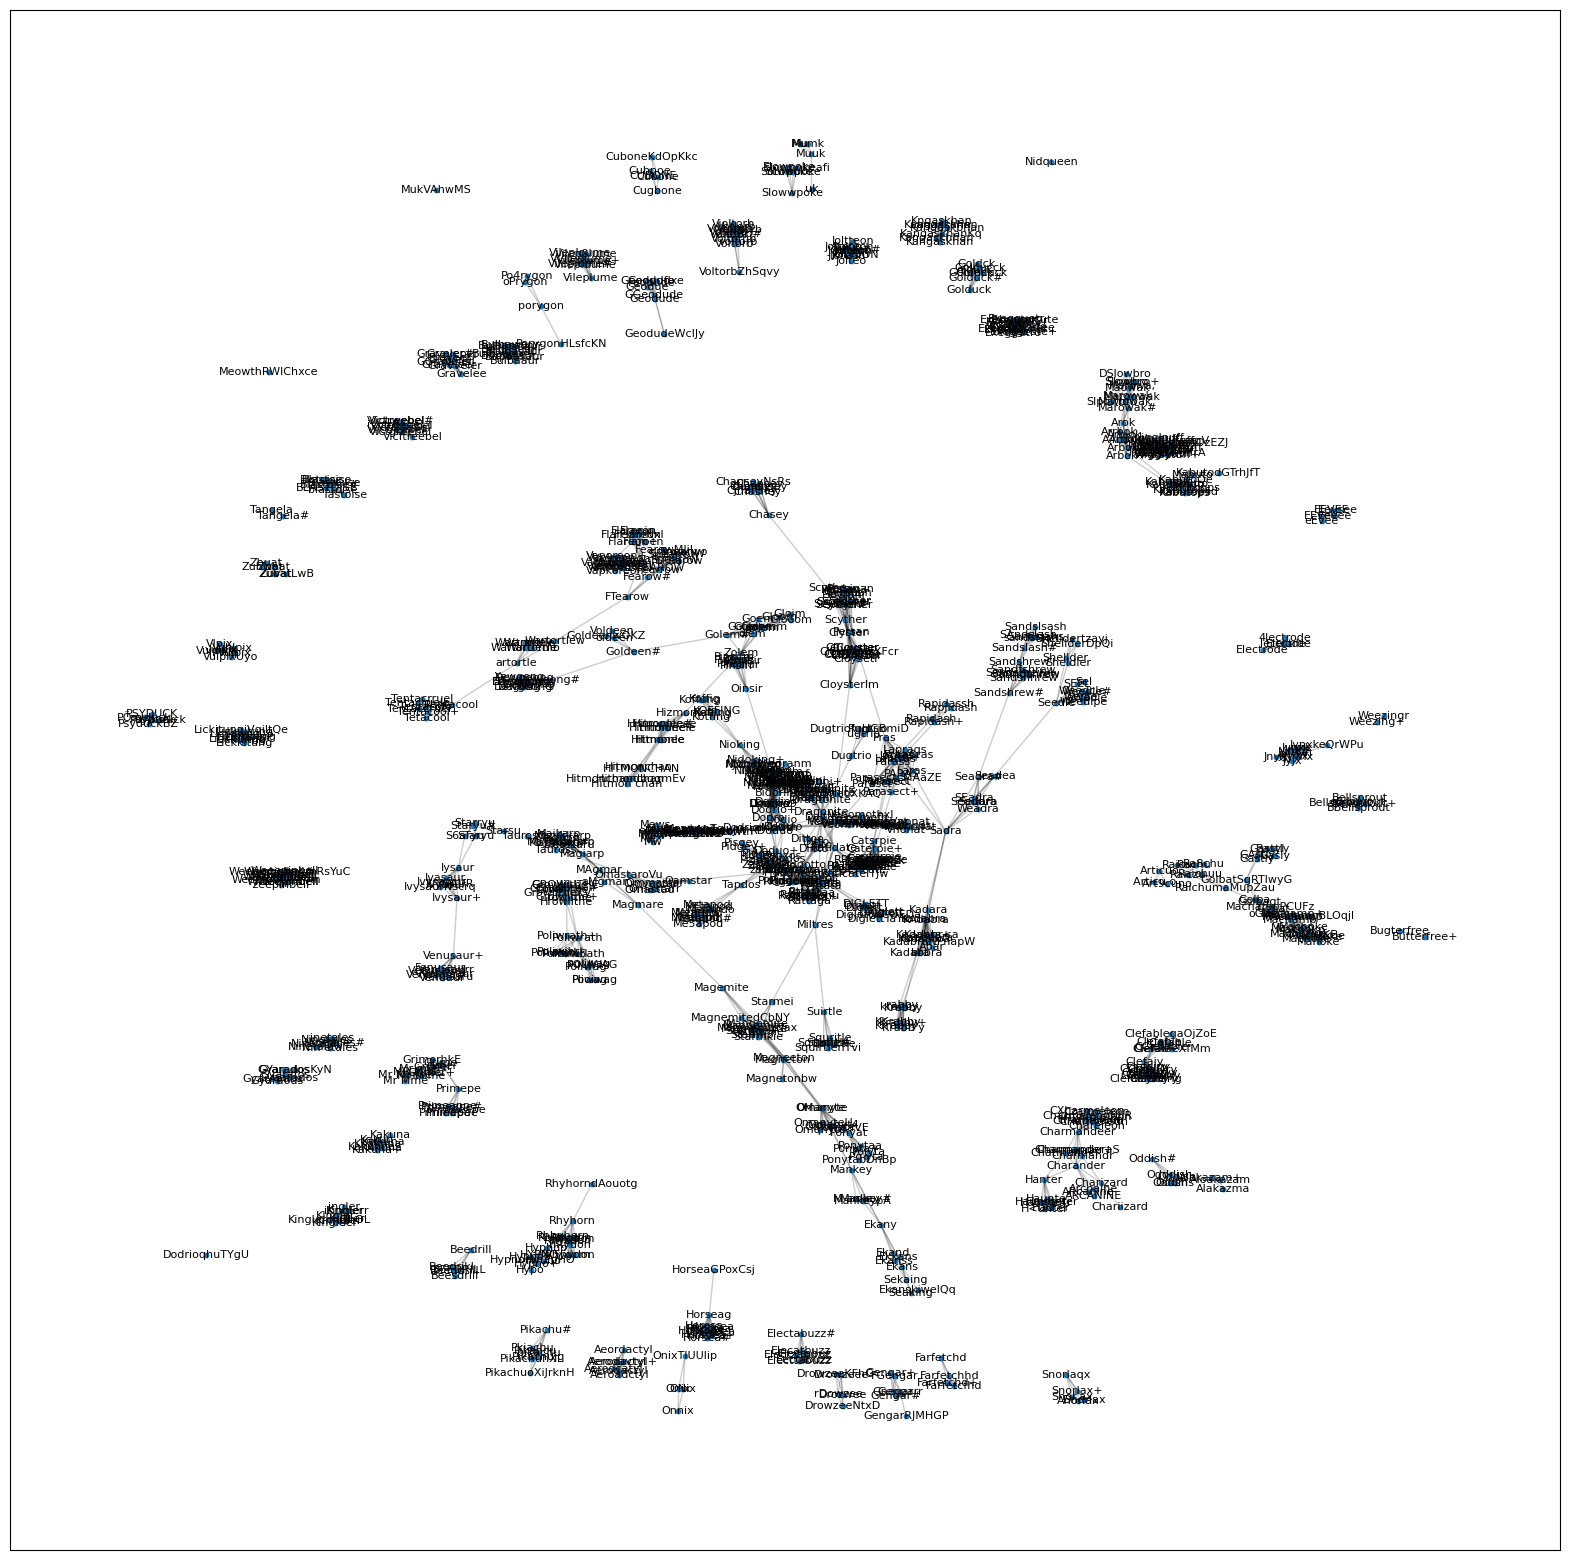

In [24]:
G = nx.from_numpy_array(adjacency_matrix*matrix)
plt.figure(1, figsize=(20,20))
draw_graph(G, labels)
plt.show()

In [25]:
for idx, word in enumerate(unique_words):
    G.nodes[idx]['title'] = word
fig_first_model = gv.three(G, node_label_data_source='title')
fig_first_model

In [26]:
y = create_y(unique_words, df)
print(f'The FMI-Score of the first model is {calculate_measures(y, adjacency_matrix)['FMI']}')

The FMI-Score of the first model is 0.8542649104429728


## 5. Hyperparameter Optimization

### 5.1 Initialize Evolutionary Algorithm

In [27]:
class individual():

    def __init__(self, num_weights):
        self.thresh = np.random.randint(0,100)/100
        self.weights = []
        for i in range(num_weights):
            self.weights.append(np.random.randint(0,100))
        for i in range(num_weights):
            self.weights[i] /= sum(self.weights)
            self.weights[i] = round(self.weights[i],2)
        return
    
    def fitness(self, matr, y)->dict:
        'Calculate fitness of individuum'

        #Create adjacency matrix
        abc = name_clustering()
        matrix = abc.matrix(matr, self.weights)
        adjacency_matrix = abc.create_adjacency_matrix(matrix, self.thresh)

        #Calculate FMI-Score
        measures = calculate_measures(y, adjacency_matrix)
        if math.isnan(measures['FMI']):
            measures['FMI'] = 0
        
        return measures['FMI']
    
    def mutation_weight(self)->None:
        'Mutate the weights of the individuum'

        #Get random gene
        gene = np.random.randint(0,len(self.weights))

        #Mutate allel
        self.weights[gene] = np.random.random()

        #Normalize genes
        for i in range(len(self.weights)):
            self.weights[i] /= sum(self.weights)
            self.weights[i] = round(self.weights[i],2)
        
        return
    
    def mutation_treshold(self)->None:
        'Mutate threshold of individuum'

        self.thresh = np.random.randint(0,100)/100

        return
    
    def repair_weights(self)->None:
        'Repair weights of individuum that sum of weights = 1'

        for i in range(len(self.weights)):
            self.weights[i] /= sum(self.weights)
            self.weights[i] = round(self.weights[i],2)
        
        return

In [28]:
def create_population(pop_size: int, num_weights: int)->list:
    'Create initial population'

    population = []
    for i in range(pop_size):
        population.append(individual(num_weights))
    
    return population

In [29]:
def calculate_fitness(population: list, matr: np.array, y: np.array)->list[float]:
    'Calculate fitness for whole population'

    fitness = []
    for i in range(len(population)):
        fitness.append(population[i].fitness(matr, y))
    
    return fitness

In [30]:
def mutation(fitness: list, mut_prob: float, population: list)->None:
    'Mutate whole population'

    #Repeat mutation as indicated by mutation probability (`mut_prob`)
    for _ in range(int(len(population) * mut_prob)):

        #Get random individuum for mutation
        weight_random = np.random.randint(0,len(population))
        thresh_random = np.random.randint(0,len(population))

        #Mutate weight of individuum
        population[weight_random].mutation_weight()
        fitness[weight_random] = population[weight_random].fitness(matr, y)

        #Mutate threshold of individuum
        population[thresh_random].mutation_treshold()
        fitness[thresh_random] = population[thresh_random].fitness(matr, y)
    
    return

In [31]:
def roullete_wheel_build(population: list, pop_fit: list[float])->list[float]:
    'Build roullete wheel for selection process'

    cum_fit = []
    sum_fit = 0
    for i in range(len(pop_fit)):
        sum_fit += pop_fit[i] / sum(pop_fit)
        cum_fit.append(sum_fit)
    
    return cum_fit

In [32]:
def select(population: list, pop_fit: list[float]):
    'Select 2 individuals for recombination'

    lst = roullete_wheel_build(population, pop_fit)
    parent_1 = lst.index(next(x for x in lst if x > 0.5)) - 1
    parent_2 = lst.index(next(x for x in lst if x > 0.5)) - 1

    return parent_1, parent_2

In [33]:
def recombination(num_weights: int, parent_1: int, parent_2: int, pop_fit: list, matr: np.array, y: np.array, population: list, kid_population: list)->None:
    'Recombine two individuals into four children'

    #Initialize children
    kid_1 = individual(num_weights)
    kid_2 = individual(num_weights)
    kid_3 = individual(num_weights)
    kid_4 = individual(num_weights)

    #Define split of genes
    split = np.random.randint(0,len(population[0].weights))

    #Create first child, repair weights, add to population and calculate fitness
    kid_1.weights = population[parent_1].weights[:split] + population[parent_2].weights[split:]
    kid_1.repair_weights()
    kid_1.thresh = population[parent_1].thresh
    kid_population.append(kid_1)
    pop_fit.append(population[-1].fitness(matr, y))

    #Create second child, repair weights, add to population and calculate fitness
    kid_2.weights = population[parent_2].weights[:split] + population[parent_1].weights[split:]
    kid_2.repair_weights()
    kid_2.thresh = population[parent_1].thresh
    kid_population.append(kid_2)
    pop_fit.append(population[-1].fitness(matr, y))

    #Create third child, repair weights, add to population and calculate fitness
    kid_3.weights = population[parent_1].weights[:split] + population[parent_2].weights[split:]
    kid_3.repair_weights()
    kid_3.thresh = population[parent_2].thresh
    kid_population.append(kid_1)
    pop_fit.append(population[-1].fitness(matr, y))

    #Create fourth child, repair weights, add to population and calculate fitness
    kid_4.weights = population[parent_2].weights[:split] + population[parent_1].weights[split:]
    kid_4.repair_weights()
    kid_4.thresh = population[parent_2].thresh
    kid_population.append(kid_2)
    pop_fit.append(population[-1].fitness(matr, y))

    return

### 5.2 Apply Evolutionary Algorithm

In [34]:
#Hyperparameters of Evolutionary Algorithm
pop_size = 15
num_weights = 4
generations = 30
recomb_rate = 10

#Initiate population
population = create_population(pop_size, num_weights)

#Create base for fitness calculation
matr = np.array([cos_array, fuzz_array, sub_array, jac_array])
y = create_y(unique_words, df)

best_fit = []
best_weight = []
best_thresh = []

for generation in range(generations):

    #Calculate Fitness
    pop_fit = calculate_fitness(population, matr, y)

    #Recombine Individuals
    kid_population = []
    kid_fit = []
    for i in range(recomb_rate):
        parent_1, parent_2 = select(population, pop_fit)
        recombination(4, parent_1, parent_2, kid_fit, matr, y, population, kid_population)
    
    #Mutate childs
    mutation(kid_fit, 0.3, kid_population)

    #Aggregate both populations
    population += kid_population
    pop_fit += kid_fit

    #Reduce population
    best_ind_idx = list(pd.DataFrame(pop_fit, columns=['fitness']).sort_values(by='fitness', ascending=False).head(pop_size).index)
    best_fit.append(pop_fit[best_ind_idx[0]])
    new_population = [population[idx] for idx in best_ind_idx]
    population = new_population
    best_weight.append(population[0].weights)
    best_thresh.append(population[0].thresh)

    print('Generation: ' + str(generation) + ', Best Fitness: ' + str(best_fit[-1]) + ', Threshold: ' + str(population[0].thresh) + ', Weights: ' + str(population[0].weights))


Generation: 0, Best Fitness: 0.8801969225278765, Threshold: 0.63, Weights: [0.01, 0.44, 0.18, 0.51]
Generation: 1, Best Fitness: 0.8801969225278765, Threshold: 0.63, Weights: [0.01, 0.44, 0.18, 0.51]
Generation: 2, Best Fitness: 0.8801969225278765, Threshold: 0.63, Weights: [0.01, 0.44, 0.18, 0.51]
Generation: 3, Best Fitness: 0.8806240822024025, Threshold: 0.57, Weights: [0.04, 0.25, 0.18, 0.5]
Generation: 4, Best Fitness: 0.8828963942688262, Threshold: 0.61, Weights: [0.09, 0.35, 0.16, 0.44]
Generation: 5, Best Fitness: 0.8828963942688262, Threshold: 0.61, Weights: [0.09, 0.35, 0.16, 0.44]
Generation: 6, Best Fitness: 0.8828963942688262, Threshold: 0.61, Weights: [0.09, 0.35, 0.16, 0.44]
Generation: 7, Best Fitness: 0.8828963942688262, Threshold: 0.61, Weights: [0.09, 0.35, 0.16, 0.44]
Generation: 8, Best Fitness: 0.8828963942688262, Threshold: 0.61, Weights: [0.09, 0.35, 0.16, 0.44]
Generation: 9, Best Fitness: 0.8828963942688262, Threshold: 0.61, Weights: [0.09, 0.35, 0.16, 0.44]
G

C:\Users\G23236\AppData\Local\Temp\ipykernel_11148\19790958.py:13: RuntimeWarning: invalid value encountered in scalar divide
  precision = true_positives / (true_positives + false_positives)


Generation: 23, Best Fitness: 0.897926538709174, Threshold: 0.67, Weights: [0.03, 0.63, 0.14, 0.3]
Generation: 24, Best Fitness: 0.897926538709174, Threshold: 0.67, Weights: [0.03, 0.63, 0.14, 0.3]
Generation: 25, Best Fitness: 0.897926538709174, Threshold: 0.67, Weights: [0.03, 0.63, 0.14, 0.3]
Generation: 26, Best Fitness: 0.897926538709174, Threshold: 0.67, Weights: [0.03, 0.63, 0.14, 0.3]
Generation: 27, Best Fitness: 0.897926538709174, Threshold: 0.67, Weights: [0.03, 0.63, 0.14, 0.3]
Generation: 28, Best Fitness: 0.897926538709174, Threshold: 0.67, Weights: [0.03, 0.63, 0.14, 0.3]
Generation: 29, Best Fitness: 0.897926538709174, Threshold: 0.67, Weights: [0.03, 0.63, 0.14, 0.3]


### 5.3 Visualize Optimization

<function matplotlib.pyplot.show(close=None, block=None)>

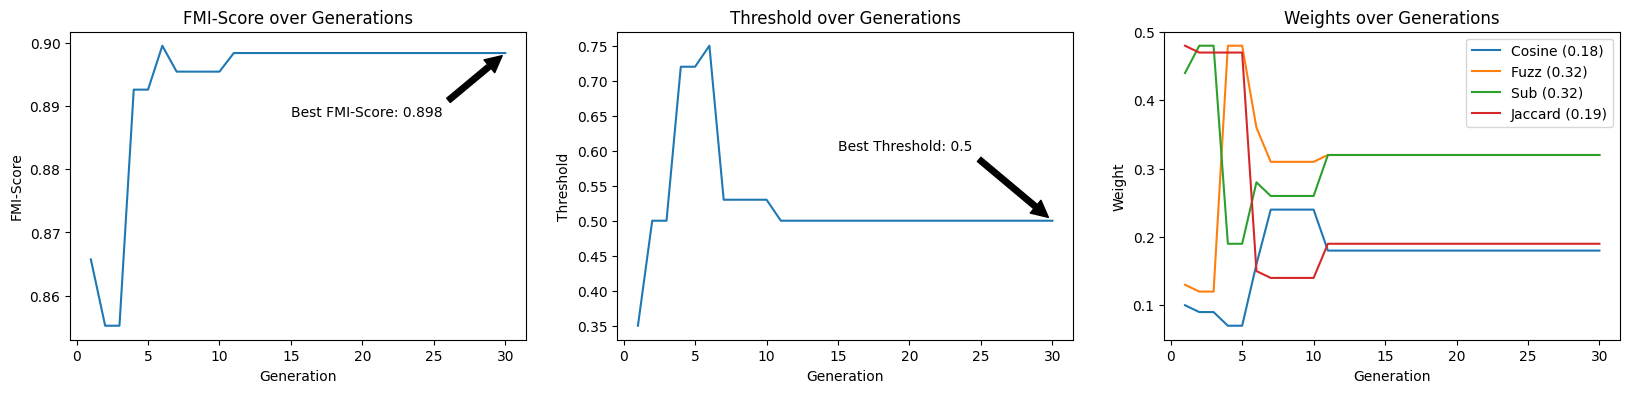

In [60]:
x_scale = [x for x in range(1, generations + 1)]

plt.figure(figsize=[20,4])

plt.subplot(131)
plt.plot(x_scale, best_fit)
plt.xlabel('Generation')
plt.ylabel('FMI-Score')
plt.title('FMI-Score over Generations')
plt.annotate('Best FMI-Score: ' + str(round(best_fit[-1],3)), [generations,best_fit[-1]], xytext=[generations/2, best_fit[-1]-0.01], arrowprops=dict(facecolor='black', shrink=0.05))

plt.subplot(132)
plt.plot(x_scale, best_thresh)
plt.xlabel('Generation')
plt.ylabel('Threshold')
plt.title('Threshold over Generations')
plt.annotate('Best Threshold: ' + str(round(best_thresh[-1],3)), [generations,best_thresh[-1]], xytext=[generations/2, 0.6], arrowprops=dict(facecolor='black', shrink=0.05))

plt.subplot(133)
weight_cos = [ind[0] for ind in best_weight]
weight_fuzz = [ind[1] for ind in best_weight]
weight_sub = [ind[2] for ind in best_weight]
weight_jac = [ind[3] for ind in best_weight]
plt.plot(x_scale, weight_cos,
         x_scale, weight_fuzz,
         x_scale, weight_sub,
         x_scale, weight_jac)
plt.xlabel('Generation')
plt.ylabel('Weight')
plt.title('Weights over Generations')
plt.legend(['Cosine (' + str(round(best_weight[-1][0],2)) + ')', 'Fuzz (' + str(round(best_weight[-1][1],2)) + ')', 'Sub (' + str(round(best_weight[-1][2],2)) + ')', 'Jaccard (' + str(round(best_weight[-1][3],2)) + ')'])

plt.show

### 5.4 Visualization of Clusters with optimised Parameters

In [36]:
abc = name_clustering()
matrix = abc.matrix(matr, best_weight[-1])
adjacency_matrix = abc.create_adjacency_matrix(matrix, best_thresh[-1])

Give the nodes labels for the visualisation

In [37]:
labels = {k: v for k, v in enumerate(unique_words)}

Create the graph-obejct an draw the 2D and 3D Visualisation

In [38]:
def draw_graph(G, labels):
    pos = nx.spring_layout(G)
    nx.draw_networkx_nodes(G, pos, node_size=10)
    nx.draw_networkx_labels(G, pos, labels, font_size=8)
    nx.draw_networkx_edges(G, pos, width=1.0, alpha=0.2)

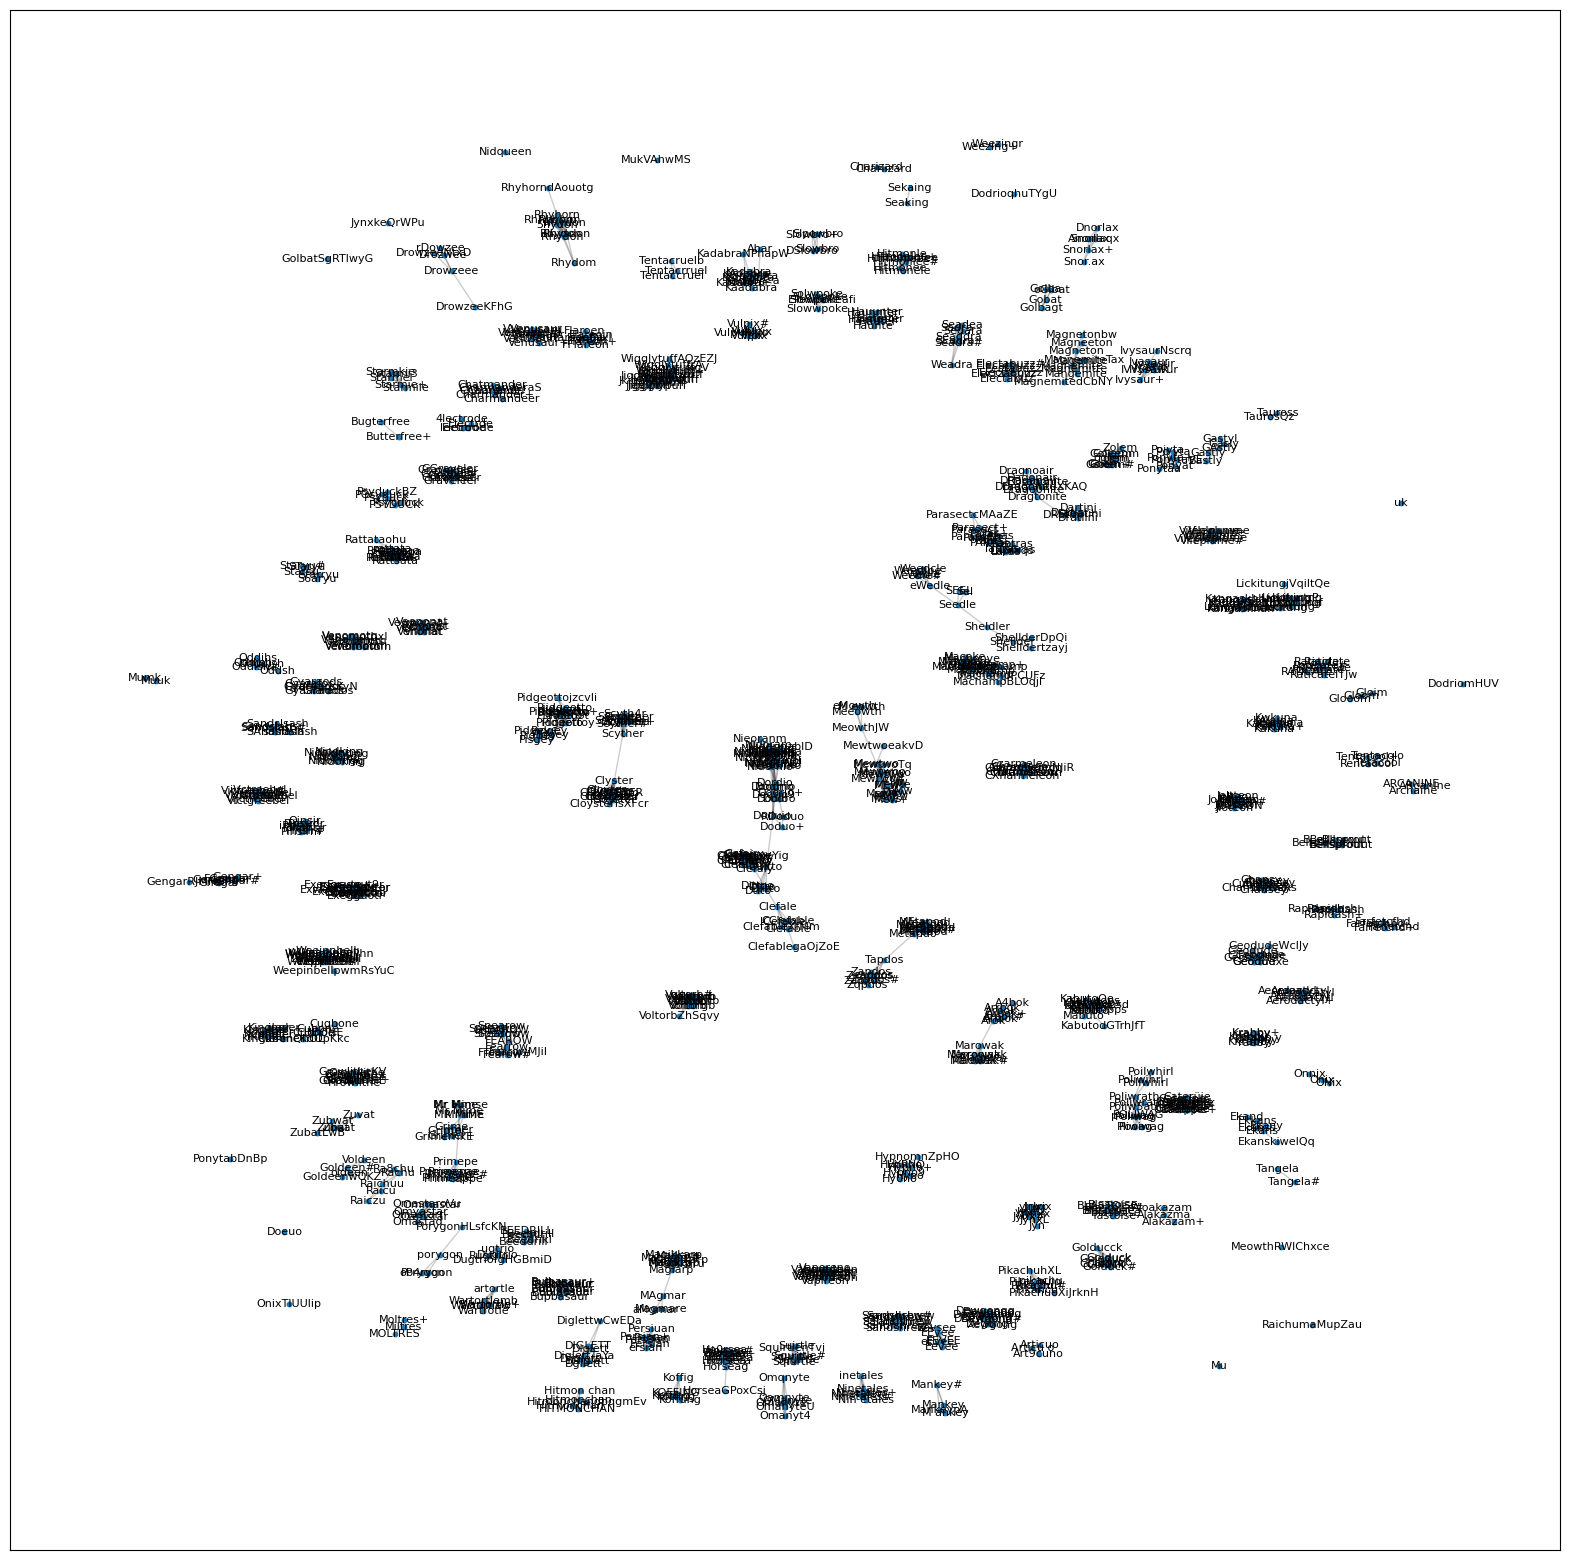

In [39]:
G = nx.from_numpy_array(adjacency_matrix*matrix)
plt.figure(1, figsize=(20,20))
draw_graph(G, labels)
plt.show()

In [40]:
for idx, word in enumerate(unique_words):
    G.nodes[idx]['title'] = word
fig_opt_model = gv.three(G, node_label_data_source='title')
fig_opt_model

## 6. Test with Train and Test split

### 6.1 Get X and y

In [41]:
X = df['word']
y = df['cluster']

Split in Train and Test

In [42]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = .30, random_state=42)

### 6.2 Training

Concate X and y of training set

In [43]:
train = pd.DataFrame(zip(X_train, y_train))
train.columns = ['word','cluster']

Get unique words

In [44]:
unique_words = list(set(train['word']))

Normalize words

In [45]:
text = normalize(unique_words)

Calculate Similarity Measures

In [46]:
cos_array = cos_sim(text)
fuzz_array = fuzz_ratio(text)
sub_array = sub_string(text)
jac_array = jaccard(text)

c:\Users\G23236\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\feature_extraction\text.py:525: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


Apply Evolutionary Algorithm

In [47]:
#Hyperparameters of Evolutionary Algorithm
pop_size = 15
num_weights = 4
generations = 30
recomb_rate = 10

#Initiate population
population = create_population(pop_size, num_weights)

#Create base for fitness calculation
matr = np.array([cos_array, fuzz_array, sub_array, jac_array])
y = create_y(unique_words, train)

best_fit = []
best_weight = []
best_thresh = []

for generation in range(generations):

    #Calculate Fitness
    pop_fit = calculate_fitness(population, matr, y)

    #Recombine Individuals
    kid_population = []
    kid_fit = []
    for i in range(recomb_rate):
        parent_1, parent_2 = select(population, pop_fit)
        recombination(4, parent_1, parent_2, kid_fit, matr, y, population, kid_population)
    
    #Mutate childs
    mutation(kid_fit, 0.3, kid_population)

    #Aggregate both populations
    population += kid_population
    pop_fit += kid_fit

    #Reduce population
    best_ind_idx = list(pd.DataFrame(pop_fit, columns=['fitness']).sort_values(by='fitness', ascending=False).head(pop_size).index)
    best_fit.append(pop_fit[best_ind_idx[0]])
    new_population = [population[idx] for idx in best_ind_idx]
    population = new_population
    best_weight.append(population[0].weights)
    best_thresh.append(population[0].thresh)

    print('Generation: ' + str(generation) + ', Best Fitness: ' + str(best_fit[-1]) + ', Threshold: ' + str(population[0].thresh) + ', Weights: ' + str(population[0].weights))

Generation: 0, Best Fitness: 0.8657251990037146, Threshold: 0.35, Weights: [0.1, 0.13, 0.44, 0.48]
Generation: 1, Best Fitness: 0.8552384462541943, Threshold: 0.5, Weights: [0.09, 0.12, 0.48, 0.47]
Generation: 2, Best Fitness: 0.8552384462541943, Threshold: 0.5, Weights: [0.09, 0.12, 0.48, 0.47]
Generation: 3, Best Fitness: 0.8925851512450416, Threshold: 0.72, Weights: [0.07, 0.48, 0.19, 0.47]
Generation: 4, Best Fitness: 0.8925851512450416, Threshold: 0.72, Weights: [0.07, 0.48, 0.19, 0.47]


C:\Users\G23236\AppData\Local\Temp\ipykernel_11148\19790958.py:13: RuntimeWarning: invalid value encountered in scalar divide
  precision = true_positives / (true_positives + false_positives)


Generation: 5, Best Fitness: 0.8995322482463369, Threshold: 0.75, Weights: [0.16, 0.36, 0.28, 0.15]
Generation: 6, Best Fitness: 0.895434623574681, Threshold: 0.53, Weights: [0.24, 0.31, 0.26, 0.14]
Generation: 7, Best Fitness: 0.895434623574681, Threshold: 0.53, Weights: [0.24, 0.31, 0.26, 0.14]
Generation: 8, Best Fitness: 0.895434623574681, Threshold: 0.53, Weights: [0.24, 0.31, 0.26, 0.14]
Generation: 9, Best Fitness: 0.895434623574681, Threshold: 0.53, Weights: [0.24, 0.31, 0.26, 0.14]
Generation: 10, Best Fitness: 0.8983741928771022, Threshold: 0.5, Weights: [0.18, 0.32, 0.32, 0.19]
Generation: 11, Best Fitness: 0.8983741928771022, Threshold: 0.5, Weights: [0.18, 0.32, 0.32, 0.19]
Generation: 12, Best Fitness: 0.8983741928771022, Threshold: 0.5, Weights: [0.18, 0.32, 0.32, 0.19]
Generation: 13, Best Fitness: 0.8983741928771022, Threshold: 0.5, Weights: [0.18, 0.32, 0.32, 0.19]
Generation: 14, Best Fitness: 0.8983741928771022, Threshold: 0.5, Weights: [0.18, 0.32, 0.32, 0.19]
Gene

Visualize Optimization

<function matplotlib.pyplot.show(close=None, block=None)>

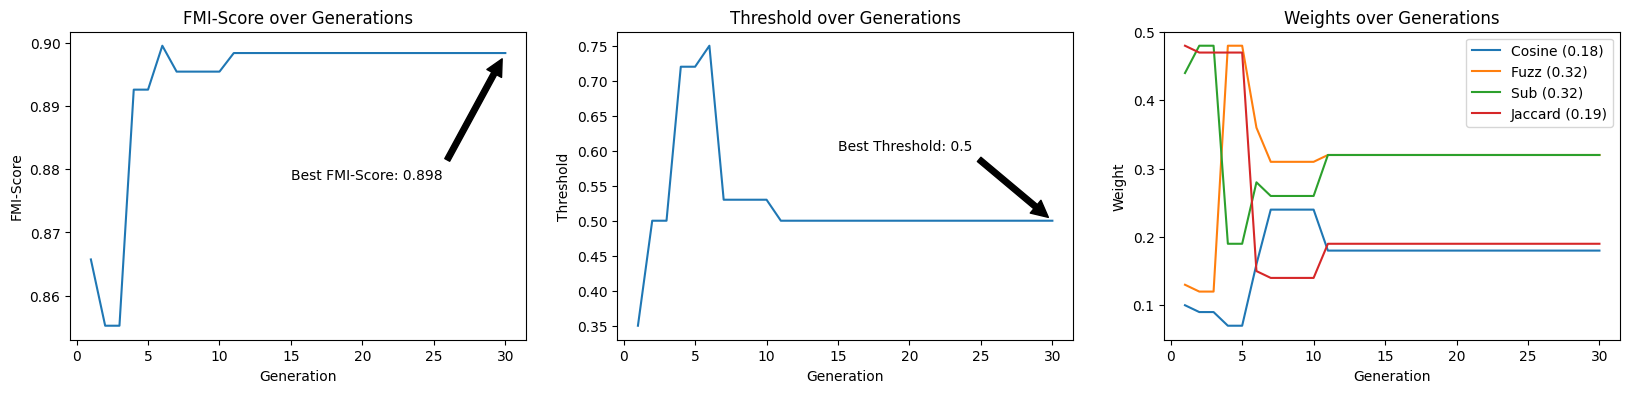

In [61]:
x_scale = [x for x in range(1, generations + 1)]

plt.figure(figsize=[20,4])

plt.subplot(131)
plt.plot(x_scale, best_fit)
plt.xlabel('Generation')
plt.ylabel('FMI-Score')
plt.title('FMI-Score over Generations')
plt.annotate('Best FMI-Score: ' + str(round(best_fit[-1],3)), [generations,best_fit[-1]], xytext=[generations/2, best_fit[-1]-0.02], arrowprops=dict(facecolor='black', shrink=0.05))

plt.subplot(132)
plt.plot(x_scale, best_thresh)
plt.xlabel('Generation')
plt.ylabel('Threshold')
plt.title('Threshold over Generations')
plt.annotate('Best Threshold: ' + str(round(best_thresh[-1],3)), [generations,best_thresh[-1]], xytext=[generations/2, 0.6], arrowprops=dict(facecolor='black', shrink=0.05))

plt.subplot(133)
weight_cos = [ind[0] for ind in best_weight]
weight_fuzz = [ind[1] for ind in best_weight]
weight_sub = [ind[2] for ind in best_weight]
weight_jac = [ind[3] for ind in best_weight]
plt.plot(x_scale, weight_cos,
         x_scale, weight_fuzz,
         x_scale, weight_sub,
         x_scale, weight_jac)
plt.xlabel('Generation')
plt.ylabel('Weight')
plt.title('Weights over Generations')
plt.legend(['Cosine (' + str(round(best_weight[-1][0],2)) + ')', 'Fuzz (' + str(round(best_weight[-1][1],2)) + ')', 'Sub (' + str(round(best_weight[-1][2],2)) + ')', 'Jaccard (' + str(round(best_weight[-1][3],2)) + ')'])

plt.show

### 6.3 Test

Concate X and y of test set

In [49]:
test = pd.DataFrame(zip(X_test, y_test))
test.columns = ['word','cluster']

Get unique words

In [50]:
unique_words = list(set(test['word']))

Normalize words

In [51]:
text = normalize(unique_words)

Calculate similarity measures

In [52]:
cos_array = cos_sim(text)
fuzz_array = fuzz_ratio(text)
sub_array = sub_string(text)
jac_array = jaccard(text)

c:\Users\G23236\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\feature_extraction\text.py:525: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


Create Adjacency Matrix

In [53]:
matr = np.array([cos_array, fuzz_array, sub_array, jac_array])
abc = name_clustering()
matrix = abc.matrix(matr, best_weight[-1])
adjacency_matrix = abc.create_adjacency_matrix(matrix, best_thresh[-1])

Visualize clusters

In [54]:
labels = {k: v for k, v in enumerate(unique_words)}

In [55]:
def draw_graph(G, labels):
    pos = nx.spring_layout(G)
    nx.draw_networkx_nodes(G, pos, node_size=10)
    nx.draw_networkx_labels(G, pos, labels, font_size=8)
    nx.draw_networkx_edges(G, pos, width=1.0, alpha=0.2)

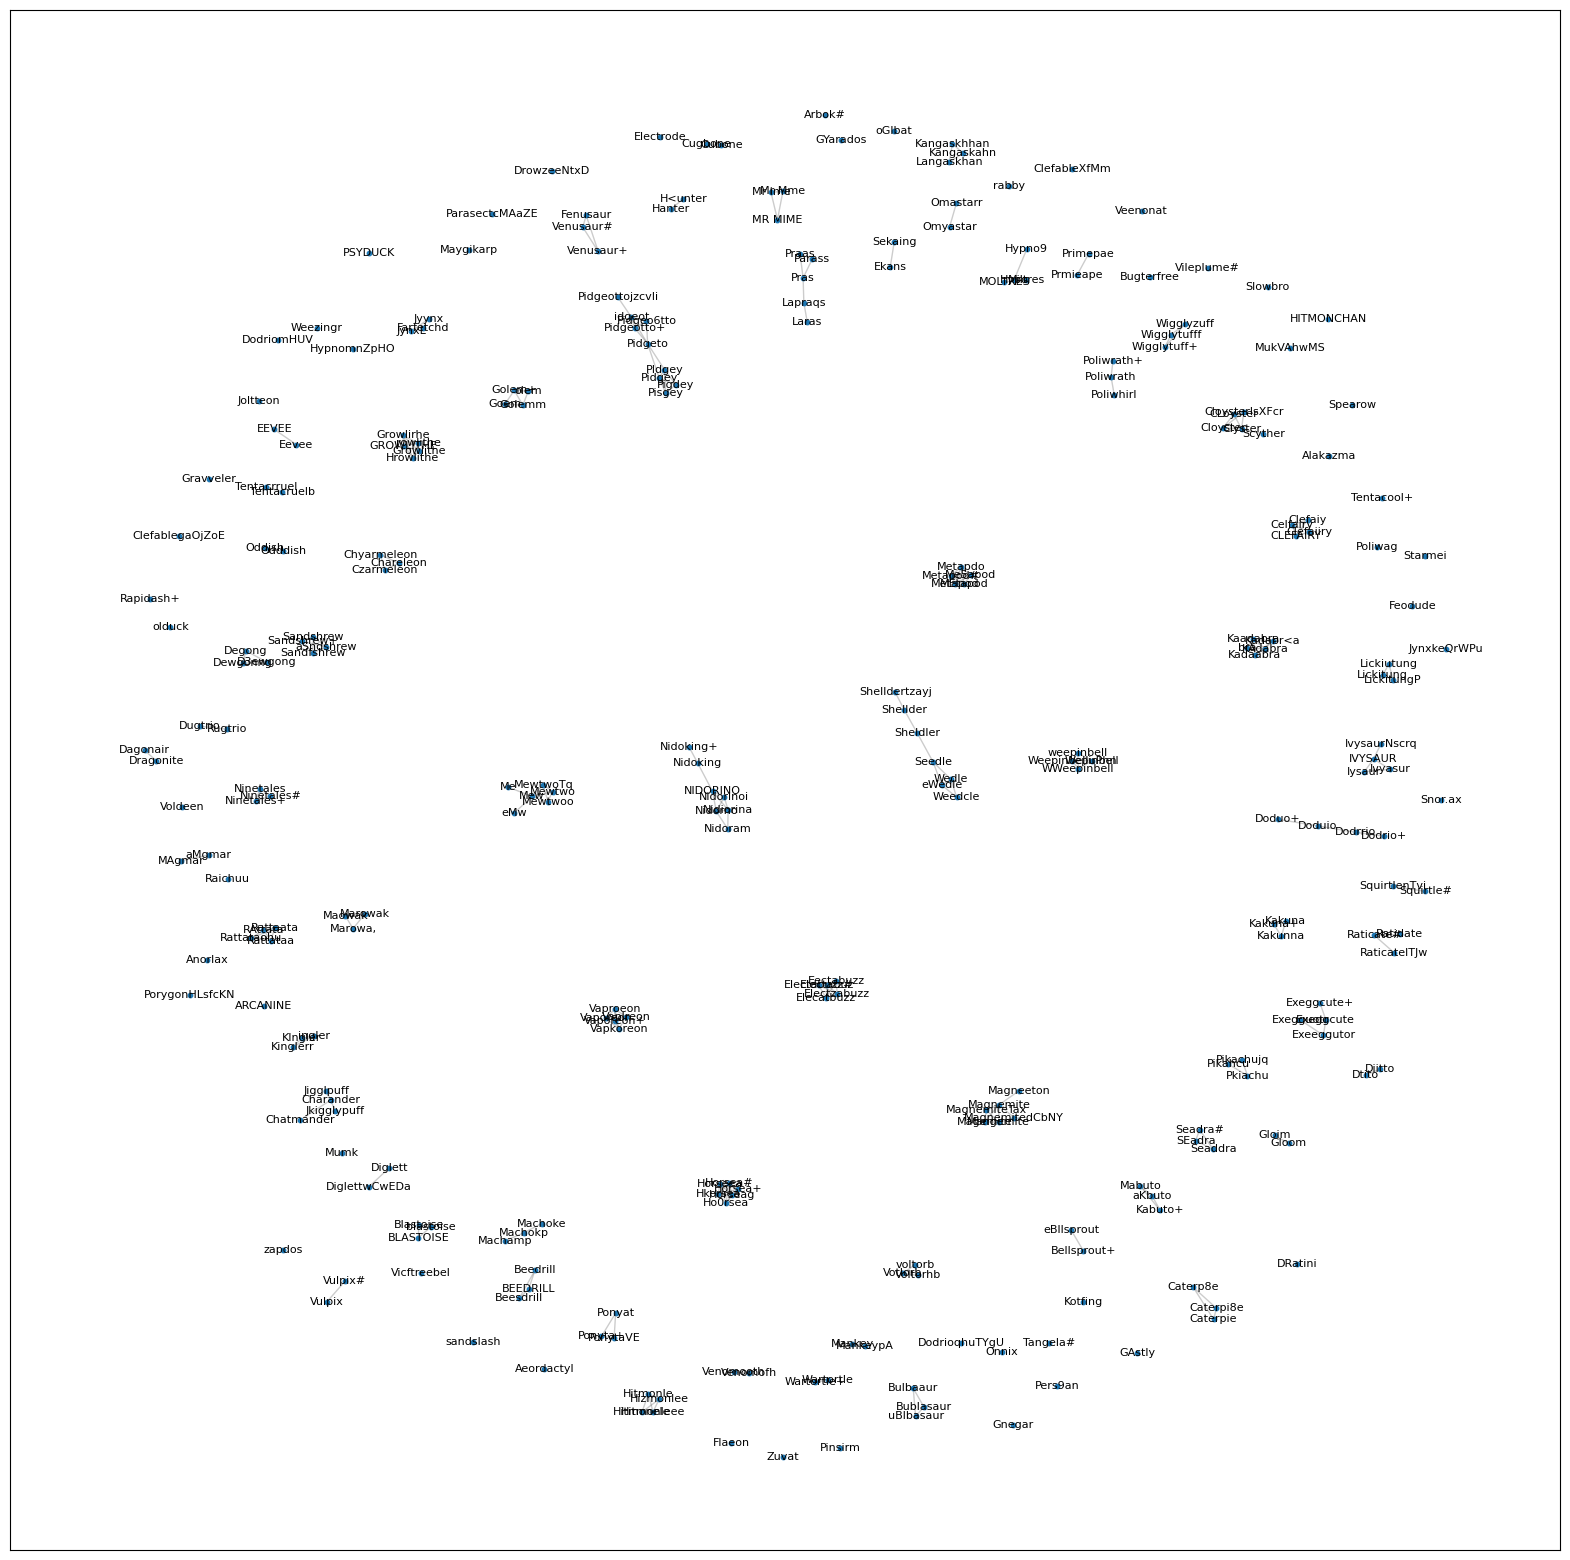

In [56]:
G = nx.from_numpy_array(adjacency_matrix*matrix)
plt.figure(1, figsize=(20,20))
draw_graph(G, labels)
plt.show()

In [57]:
for idx, word in enumerate(unique_words):
    G.nodes[idx]['title'] = word
fig_test = gv.three(G, node_label_data_source='title')
fig_test

Calculate Goodness

In [58]:
y = create_y(unique_words, test)
print(f'The FMI-Score of the test model is {calculate_measures(y, adjacency_matrix)['FMI']}')

The FMI-Score of the test model is 0.8958597412879643
